In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
# from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net_regular

    
import Resnet_multiscale_general as net


mse_list = list()
step_size_list = list()
noise_list = list()
t_list_all = list()


In [49]:
#===========================================================================================================

# adjustables

system = 'VanDerPol'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'
# system = 'Lorenz'

noise = 0.0                  # noise percentage: 0.00, 0.01 or 0.02
letter = 'b'

step_sizes = [4, 8, 16]#[4, 8, 216]
if system == 'KS' or system == "KS_new":
    smallest_step = 4
    dt = 0.025
    arch = [512, 2048, 512]
elif system == "VanDerPol":
    smallest_step = 4
    dt = 0.01
    arch = [2, 512, 512, 512, 2]
elif system == "Lorenz":
    smallest_step = 16
    dt = 0.0005
    arch = [3, 1024, 1024, 1024, 3]
else:
    print("system not available")
    raise SystemExit()
    
n_poss = 1773
    

lr = 1e-3                     # learning rate
max_epoch = 500000            # the maximum training epoch 
batch_size = 320              # training batch size
# arch = [512, 2048, 512]  # architecture of the neural network, KS


# paths
data_dir = os.path.join('../../data/', system,)
model_dir = os.path.join('../../models/', system)#, '{}_{}'.format(system, str(n_poss),)) #'../../models/'  VanDerPol'
#     model_dir = '../../models/VanDerPol_multiscale'
# model_dir = '../../models/KS_'+str(n_poss)


# load data
train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
try:
    val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
except:
    #just use training data for all if validation and testing not there
    print("validation not found, using trainin")
    val_data= train_data
try:
    test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
except:
    #just use training data for all if validation and testing not there
    print("testing not found, using training ")
    test_data=train_data
    
n_steps = train_data.shape[1]
    
n_train = train_data.shape[0]
n_val = val_data.shape[0]
n_test = test_data.shape[0]

print("train_data shape = ", train_data.shape)
print("val_data shape = ", val_data.shape)
print("test_data.shape = ", test_data.shape)


# for step_size in [smallest_step]:#,8,16,32]:

#     for letter in ['a']:
    #make and train
model_name = 'model_{}_depends{}_noise{}_{}.pt'.format(system, n_poss, noise, letter)
# model_name = 'model_{}_depends{}_stepsize4_noise{}_{}.pt'.format(system, n_poss, noise, letter)
print("train_data shape = ", train_data.shape)
print("val_data shape = ", val_data.shape)
print("test_data.shape = ", test_data.shape)


model = torch.load(os.path.join(model_dir, model_name), map_location='cpu')
model.device = 'cpu'
for step_size in model.step_sizes:
    model._modules[str(step_size)]._modules['activation'] = torch.nn.ReLU()


validation not found, using trainin
train_data shape =  (500, 80, 512)
val_data shape =  (500, 80, 512)
test_data.shape =  (10, 3840, 512)
train_data shape =  (500, 80, 512)
val_data shape =  (500, 80, 512)
test_data.shape =  (10, 3840, 512)


In [28]:
#want to find mse when just considering the smaller timescale

def predict_single_scale(model1, step_size, test_data=test_data, timesteps = 5000, size='small', to_plot=True):

    t = 0
    print(step_size)

    n_timepoints = timesteps // step_size + 1
    
    n_test_points, _, ndim = test_data.shape


    t_list = np.zeros(n_timepoints)
    y_pred_list = np.zeros((n_test_points, n_timepoints, ndim))

    t+= step_size
    y_preds = model1.forward(torch.tensor(test_data[:, 0]).float(), size)
    y_pred_list[:,0] = y_preds.detach().numpy()
    t_list[0] = t
    print(y_preds.shape)

    for j in range(n_timepoints-1):
        t+= step_size
        y_preds = model1.forward(y_preds, size)

        y_pred_list[:,j+1] = y_preds.detach().numpy()
        t_list[j+1] = t

    
    # need to interpolate between timesteps
    y_pred_list_new = np.zeros((n_test_points, timesteps - step_size, ndim))
    t_list_new = np.arange(step_size, timesteps)
    for i in range(len(y_pred_list)):
        for j in range(2):
            f = interp1d(t_list, y_pred_list[i,:,j])
            y_pred_list_new[i,:,j] = f(t_list_new)
    
    plt_idx = 0
    
    if to_plot:

        plt.plot(t_list_new, test_data[plt_idx,t_list_new.astype(int), 1])
        plt.plot(t_list_new, test_data[plt_idx,t_list_new.astype(int), 0])
#         plt.plot(t_list_new, test_data[plt_idx,t_list_new.astype(int), 2])

        plt.plot(t_list_new, y_pred_list_new[plt_idx,:, 1])
        plt.plot(t_list_new, y_pred_list_new[plt_idx,:, 0])
#         plt.plot(t_list_new, y_pred_list_new[plt_idx,:, 2])
        plt.title(system + ": step_size = " + str(step_size)+ ": noise = "+ str(noise))
    
        plt.ylim([np.min(test_data),np.max(test_data)])

        plt.show()
    
    mse = np.mean((y_pred_list_new - test_data[:,t_list_new.astype(int)])**2, axis = (0,2))
    if to_plot:
        plt.semilogy(t_list_new, mse)
        plt.title(system + ": step_size = " + str(step_size)+ ": noise = "+ str(noise))
        plt.show()
    
    
    return y_pred_list_new, mse, t_list_new
 




5121
4
torch.Size([320, 2])


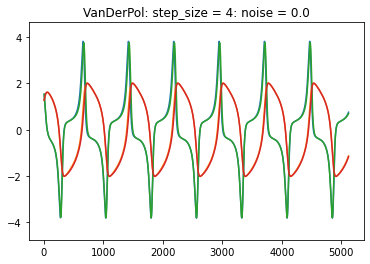

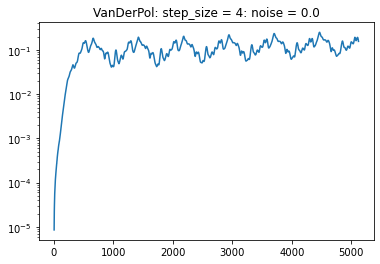

8
torch.Size([320, 2])


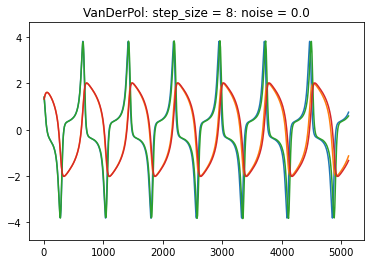

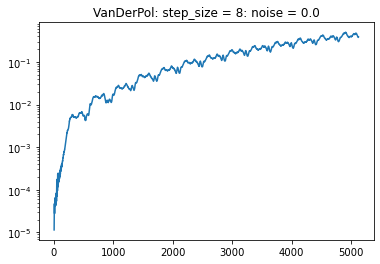

16
torch.Size([320, 2])


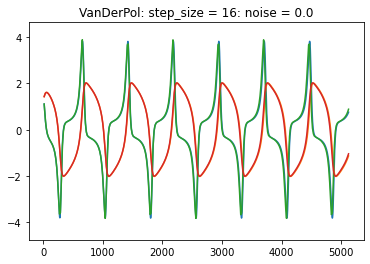

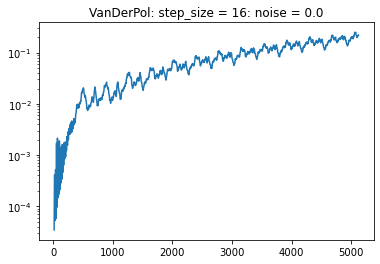

In [29]:
to_plot = True
# y_pred_list = list()
# mse_list = list()
# t_list = list()

# for i in [1,2,4]:
timesteps = test_data.shape[1]
print(timesteps)
    
y_pred_list_small, mse_small, t_list = predict_single_scale(model, step_sizes[0], test_data=test_data, timesteps = timesteps, 
                                                            size=str(step_sizes[0]), to_plot=to_plot)
y_pred_list_mid, mse_mid, t_list_mid = predict_single_scale(model, step_sizes[1], test_data=test_data, timesteps = timesteps, 
                                                            size=str(step_sizes[1]),to_plot=to_plot)
y_pred_list_large, mse_large, t_list_large = predict_single_scale(model, step_sizes[2], test_data=test_data, timesteps = timesteps, 
                                                                  size=str(step_sizes[2]),to_plot=to_plot)

# y_pred_list_small, mse_small, t_list = predict_single_scale(models[0], 64, test_data=test_data, timesteps = 5000, 
#                                                             size='64', to_plot=to_plot)
# y_pred_list_mid, mse_mid, t_list_mid = predict_single_scale(models[0], 128, test_data=test_data, timesteps = 5000, 
#                                                             size='128',to_plot=to_plot)
# y_pred_list_large, mse_large, t_list_large = predict_single_scale(models[0], 256, test_data=test_data, timesteps = 5000, 
#                                                                   size="256",to_plot=to_plot)


(320, 5117, 2)
(5117,)


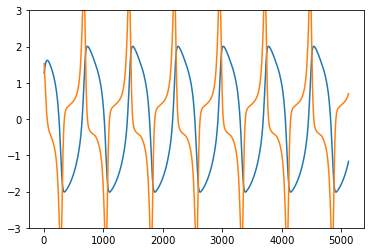

In [30]:
print(y_pred_list_small.shape)
print(t_list.shape)
plt.plot(t_list, y_pred_list_small[0,:])
plt.ylim([-3, 3])
plt.show()

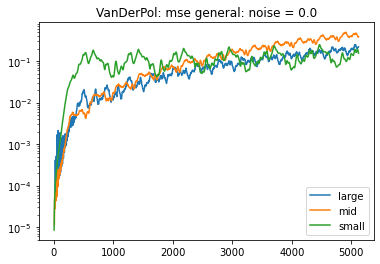

In [32]:

plt.semilogy(t_list_large, mse_large, label = "large")
plt.plot(t_list_mid, mse_mid, label = "mid")
plt.plot(t_list, mse_small, label = "small")
plt.title(system + ": mse general: noise = " + str(noise))

plt.legend()

In [33]:
import scipy

def vectorized_multi_scale_forecast(x_init, n_steps, models, step_sizes = [8,4]):
        """
        :param x_init: initial state torch array of shape n_test x n_dim
        :param n_steps: number of steps forward in terms of dt
        :param models: a list of models
        :return: a torch array of size n_test x n_steps x n_dim,
                 a list of indices that are not achieved by interpolations
        """
        # sort models by their step sizes (decreasing order)
#         step_sizes = [model.step_size for model in models]
#         step_sizes = 
#         models = [model for _, model in sorted(zip(step_sizes, models), reverse=True)]

        

        # we assume models are sorted by their step sizes (decreasing order)
        n_test, n_dim = x_init.shape
        device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
        indices = list()
        extended_n_steps = n_steps + max(models.step_sizes) #models[0].step_size
        preds = torch.zeros(n_test, extended_n_steps + 1, n_dim).float().to(device)

        # vectorized simulation
        indices.append(0)
        preds[:, 0, :] = x_init
        total_step_sizes = n_steps
#         for model in models:
#         type_models = [16, 8, 4]#['large', 'small']
#         for i in [0, 1, 2]:
#         step_sizes = [216, 8, 4]
        for step_size in step_sizes:
#             step_size = step_sizes[i]
            type_model = str(step_size)#type_models[i]
            n_forward = int(total_step_sizes/step_size)
            y_prev = preds[:, indices, :].reshape(-1, n_dim)
            indices_lists = [indices]
            for t in range(n_forward):
                y_next = models.forward(y_prev, str(type_model))
                shifted_indices = [x + (t + 1) * step_size for x in indices]
                indices_lists.append(shifted_indices)
                preds[:, shifted_indices, :] = y_next.reshape(n_test, -1, n_dim)
                y_prev = y_next
            indices = [val for tup in zip(*indices_lists) for val in tup]
            total_step_sizes = step_size - 1

        # simulate the tails
        last_idx = indices[-1]
        y_prev = preds[:, last_idx, :]
        while last_idx < n_steps:
            last_idx += step_sizes[-1]
            type_model = str(step_sizes[-1])#type_models[-1]
            y_next = models.forward(y_prev, type_model)
            preds[:, last_idx, :] = y_next
            indices.append(last_idx)
            y_prev = y_next

        # interpolations
        sample_steps = range(1, n_steps+1)
        valid_preds = preds[:, indices, :].detach().numpy()
        cs = scipy.interpolate.interp1d(indices, valid_preds, kind='linear', axis=1)
        y_preds = torch.tensor(cs(sample_steps)).float()

        return y_preds
    
n_steps = 5000
y_preds = vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps, model, step_sizes = [16, 8,4])
# plt.plot(y_preds)

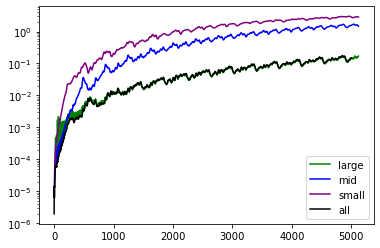

In [15]:
plt.semilogy(t_list_large, mse_large, 'g',  label = "large")
plt.plot(t_list_mid, mse_mid, 'b' , label = "mid")
plt.plot(t_list, mse_small, 'purple', label = "small")
mse = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
plt.semilogy(mse, 'black', label = "all")
plt.legend()
# plt.ylim([0.001, 1e5])

In [34]:
import random
all_combos = np.load('all_combos_'+str(smallest_step)+'.npy', allow_pickle=True)
print(all_combos)
def predict_random_combo(model1, test_data=test_data, timesteps = 5000, to_plot=True):

    t = 0
    
    idx_combo = random.sample(range(len(all_combos)), 1)
    path = all_combos[idx_combo[0]]
    print(path)
    
    steps_per_combo = sum(path)

    path_loops = timesteps // steps_per_combo - 1
    
#     print("path_loops = ", path_loops)
    n_timepoints = path_loops * len(path)
    print("n_steps = ", n_timepoints)
    
    n_test_points, _, ndim = test_data.shape


    t_list = np.zeros(n_timepoints)
    y_pred_list = np.zeros((n_test_points, n_timepoints, ndim))

    this_step_size = path[0]
    t+= this_step_size
    y_preds = model1.forward(torch.tensor(test_data[:, 0]).float(), str(this_step_size))
    y_pred_list[:,0] = y_preds.detach().numpy()
    t_list[0] = t
#     print(y_preds.shape)

    for j in range(n_timepoints-1):
        this_step_size = path[j%len(path)]
        t+= this_step_size
        y_preds = model1.forward(y_preds, str(this_step_size))

        y_pred_list[:,j+1] = y_preds.detach().numpy()
        t_list[j+1] = t
        
    print("max t = ", max(t_list))
    if to_plot:
        plt.plot(t_list, y_pred_list[0,:,0])
        plt.plot(t_list, test_data[0,t_list.astype(int), 0])
        plt.title("step_size = " + str(step_size)+ ": noise = "+ str(noise))
        plt.show()
    
    mse = np.mean((y_pred_list - test_data[:,t_list.astype(int)])**2, axis = (0,2))
    if to_plot:
        plt.semilogy(t_list, mse)
        plt.title("step_size = " + str(step_size)+ ": noise = "+ str(noise))
        plt.show()
    
    return y_pred_list, mse, t_list, path

num_lines = 50
mse_list = list()
t_list_list = list()
path_list = list()
y_pred_list = list()

for i in range(num_lines):
    print("i = ", i)
    y_preds_random, mse_random, t_list_random, path_random = predict_random_combo(model, to_plot = False,  timesteps = 5000)#timesteps-(smallest_step*4))
    y_pred_list.append(y_preds_random[0,:])
    mse_list.append(mse_random)
    t_list_list.append(t_list_random)
    path_list.append(path_random)

[(4, 4) (8,) (4, 4, 4) ... (16, 16, 8, 16, 4) (16, 16, 16, 4, 8)
 (16, 16, 16, 8, 4)]
i =  0
(16, 16, 8, 4, 4, 8, 4)
n_steps =  574
max t =  4932.0
i =  1
(4, 8, 8, 16, 4, 4, 8)
n_steps =  665
max t =  4936.0
i =  2
(8, 8, 8, 8, 8, 8, 4)
n_steps =  665
max t =  4944.0
i =  3
(4, 4, 16, 8, 4, 8, 8)
n_steps =  665
max t =  4936.0
i =  4
(8, 16, 4, 8, 8, 4, 4)
n_steps =  665
max t =  4944.0
i =  5
(16, 4, 16, 4, 8, 8, 4)
n_steps =  574
max t =  4932.0
i =  6
(8, 8, 16, 8, 4, 4, 4)
n_steps =  665
max t =  4944.0
i =  7
(8, 8, 8, 8, 4, 8, 4, 8, 4)
n_steps =  738
max t =  4924.0
i =  8
(8, 8, 4, 8, 4)
n_steps =  775
max t =  4964.0
i =  9
(8, 16, 4, 16, 4)
n_steps =  515
max t =  4948.0
i =  10
(8, 4, 8, 16, 4, 4, 8)
n_steps =  665
max t =  4940.0
i =  11
(4, 8, 4, 8, 4, 8, 8, 8, 8)
n_steps =  738
max t =  4916.0
i =  12
(8, 8, 8, 4, 4)
n_steps =  775
max t =  4964.0
i =  13
(16, 4, 8, 4, 8, 8, 4, 8)
n_steps =  656
max t =  4928.0
i =  14
(4, 16, 4, 16, 8, 4)
n_steps =  570
max t =  4940.0
i

(50, 10000, 2)
60.0
(1244,)
(1244, 2)


/tmp/ipykernel_719/2383021865.py:13: RuntimeWarning: Mean of empty slice
  means = np.nanmean(to_ave[:, 1:], axis=0)
/root/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


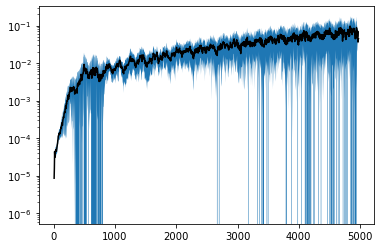

In [43]:
def find_ave_random_paths(t_list_list, mse_list):
    to_ave = np.zeros((num_lines, 10000, test_data.shape[-1]))
    print(to_ave.shape)
    i = 0 
    j = 4
    print(t_list_list[i][j])
    for i in range(num_lines):
        for j in range(len(t_list_list[i])):
            to_ave[i, int(t_list_list[i][j])] = mse_list[i][j]

    averages = np.zeros(10000)
    to_ave[to_ave == 0] = np.nan
    means = np.nanmean(to_ave[:, 1:], axis=0)
    stds = np.nanstd(to_ave[:, 1:], axis=0)

    mask = np.isfinite(means[:,0])
    ts = np.arange(1, 10000)
    
    return ts[mask], means[mask], stds[mask]
ts, means, stds = find_ave_random_paths(t_list_list, mse_list)
print(ts.shape)
print(means.shape)

# for i in range(len(mse_list)):
#     plt.semilogy(t_list_list[i], mse_list[i], 'r', linewidth = 0.5)#, label = path_list[i])
    
plt.semilogy(ts, means[:,0], 'k')
plt.fill_between(ts, means[:,0] - stds[:,0], means[:,0] + stds[:,0])

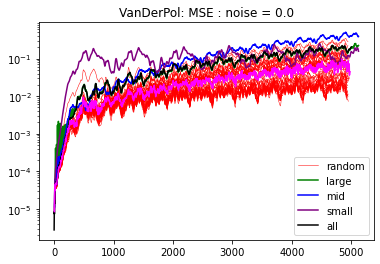

In [36]:
for i in range(len(mse_list)):
    plt.semilogy(t_list_list[i], mse_list[i], 'r', linewidth = 0.5)#, label = path_list[i])
    
plt.semilogy(t_list_list[i], mse_list[i], 'r', linewidth = 0.5, label="random")
plt.semilogy(t_list_large, mse_large, 'g',  label = "large")
plt.plot(t_list_mid, mse_mid, 'b' , label = "mid")
plt.plot(t_list, mse_small, 'purple', label = "small")
mse = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
plt.semilogy(mse, 'black', label = "all")
plt.legend()
plt.title(system + ": MSE : noise = " + str(noise))
plt.semilogy(ts, means[:,0], 'magenta')
# plt.xlim([0,1000])
# plt.title("Test mse with different paths: Model 29")

/root/miniconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


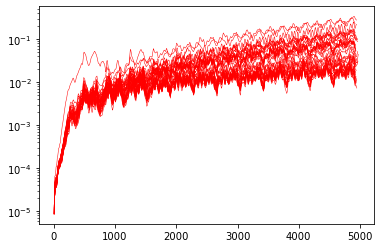

In [48]:
np.save("t_cloud.npy",t_list_list, allow_pickle=True)
np.save("mse_cloud.npy", mse_list, allow_pickle=True)

for i in range(len(mse_list)):
    plt.semilogy(t_list_list[i], mse_list[i], 'r', linewidth = 0.5)#, label = path_list[i])

In [37]:
np.save("ts_vbp.npy", ts)
np.save("means_vdp.npy", means)
np.save("mse_high_vdp.npy", mse)

In [ ]:
square_error = np.mean((y_pred_list_large - test_data[:,t_list_large.astype(int)])**2, axis = 2)
square_error_small = np.mean((y_pred_list_small - test_data[:,t_list.astype(int)])**2, axis = 2)

print(square_error.shape)
print(square_error)
print(np.argmax(square_error[:,-1]))

In [ ]:
# plt.plot(square_error[10])
plt.plot(y_pred_list_large[63])
plt.plot(square_error[63])
plt.plot(test_data[63,t_list_large.astype(int)])
plt.show()
plt.plot(y_pred_list_large[62])
plt.plot(square_error[62])


In [ ]:
# plt.plot(square_error[10])
print(len(t_list_list[-1]))
print(len(t_list_list))
print(y_preds_random.shape)
print(y_preds_random[2].shape)
square_error_random = np.mean((y_preds_random[63] - test_data[63:64, t_list_list[-1].astype(int)])**2, axis = 2)
# plt.plot(y_preds_random[63])
# plt.plot(test_data[63, t_list_list[-1].astype(int)])
plt.plot(square_error_random[0])
plt.show()



In [ ]:
# plt.plot(square_error[10])
plt.plot(y_pred_list_small[63])
plt.plot(square_error_small[63])
plt.show()
plt.plot(y_pred_list_small[62])
plt.plot(square_error_small[62])


In [ ]:
plt.plot(test_data[63],'r')
plt.plot(y_pred_list_large[63], 'b')
# plt.plot(y_pred_list_mid[0], 'g')
# plt.plot(y_pred_list_small[0], 'y')
for i in range(len(y_pred_list)):
    plt.plot(t_list_list[0],y_pred_list[0])

# plt.xlim([0,1000])

In [ ]:
mse = torch.mean((y_preds - torch.tensor(test_data[:, 1:1+n_steps, :]).float())**2, axis = (0,2))
plt.semilogy(mse, label = "all")

plt.semilogy(t_list_large, mse_large, label = "large")
plt.plot(t_list_mid, mse_mid, label = "mid")
plt.plot(t_list, mse_small, label = "small")
plt.title("mse general: noise = " + str(noise))
plt.legend()